In a [another notebook](./explore_data_and_model.ipynb) we explored the Fashion MNIST image data set and the CNN model used to classify them. 

In this notebook, we'll train the model, tune it a bit, and finally test it.

We're going to use Amazon's Sagemaker cloud service to overcome local resource limitations.
We'll take advantage of its convenient [Python SDK](https://sagemaker.readthedocs.io/en/stable/) which manages AWS resources for us behind the scenes. A [`ml.p3.2xlarge` instance](https://aws.amazon.com/sagemaker/pricing/instance-types/) will significantly speed up training and choosing managed spot instances will yield considerable savings (usually 60-70%).

## Setup

In [1]:
import numpy as np
import pandas as pd
import os
import sagemaker
import boto3
import h5py

%matplotlib inline
import matplotlib.pyplot as plt

from sagemaker.tensorflow import TensorFlow
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner
from cnn import FashionMNISTCNN as fmc

# filter out FutureWarnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

# Supress Tensorflow Warnings
import tensorflow.compat.v1.logging as logging
logging.set_verbosity(logging.ERROR)

/anaconda3/envs/fashion/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/anaconda3/envs/fashion/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/anaconda3/envs/fashion/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/anaconda3/envs/fashion/lib/python3.7/site-packages/tensorflow/python/framework

## Training

Sagemaker will run the training script inside a (prebuilt) Docker container and will pull data from an s3 bucket we specify. The container will be torn down on completion of the training job but we can send container files to an s3 bucket before that. In particular, we'll send the validation accuracy improvement checkpoints and training history generated by our training script `train_script_sagemaker.py`.

We'll use the same s3 bucket for all of this. First we'll upload local data to the bucket, then create a directory for storing keras checkpoints and history. Finally we'll specify a path for the "model artifacts" of the training job, i.e. anything saved in the `opt/ml/model` directory of the training job container. In our case, this is just the Tensorflow serving model.



### Set up s3

In [34]:
# Session info
sess = sagemaker.Session()
role_name = '<YOUR IAM ROLE NAME>'
bucket_name = '<YOUR BUCKET NAME>'

# upload data to s3
training_input_path   = sess.upload_data('data/train.hdf5', bucket=bucket_name, key_prefix='data')
validation_input_path = sess.upload_data('data/val.hdf5', bucket=bucket_name, key_prefix='data')
test_input_path = sess.upload_data('data/test.hdf5', bucket=bucket_name, key_prefix='data')

In [35]:
# create checkpoint directory in s3
try:
    with open('models/keras_checkpoints/dummy.txt', 'x') as f:
        f.write('This is a dummy file')
except OSError:
    pass

checks_output_path = sess.upload_data('models/keras_checkpoints/dummy.txt', bucket=bucket_name, key_prefix='keras-checkpoints')
checks_output_path = os.path.dirname(checks_output_path)

# s3 path for job output
job_output_path = 's3://{}/'.format(bucket_name)

### Run a single training job

We'll run a single Sagemaker training job using the [default model]('./explore_data_and_model.ipynb/#keras-cnn-model-for-classification')

We use a `sagemaker.tensorflow.Tensorflow` estimator for this training job. We'll track loss and accuracy metrics for both training and validation data, which keras tracks by default. 

Note that our output path for keras checkpoints gets passed in as a hyperparameter.

In [16]:
# objective and metric
metric_definitions = [{'Name': 'acc',
                       'Regex': 'acc: ([0-9\\.]+)'},
                      {'Name': 'val_acc',
                       'Regex': 'val_acc: ([0-9\\.]+)'},
                      {'Name': 'loss',
                       'Regex': 'loss: ([0-9\\.]+)'},
                      {'Name': 'val_loss',
                       'Regex': 'val_loss: ([0-9\\.]+)'}]


hyperparameters = {'epochs': 100, 'batch-size': 100, 'drop-rate': 0.5,
                   'checks-out-path': checks_output_path}

# create sagemaker estimator
tf_estimator = TensorFlow(entry_point='train_script_sagemaker.py', 
                          role=role_name,
                          train_volume_size=5,
                          train_instance_count=1, 
                          train_instance_type='ml.p3.2xlarge',
                          train_use_spot_instances=True,
                          train_max_wait=86400,
                          output_path=job_output_path,
                          framework_version='1.14', 
                          py_version='py3',
                          script_mode=True,
                          hyperparameters=hyperparameters,
                          metric_definitions=metric_definitions
                         )

paths = {'train': training_input_path, 'val': validation_input_path,
         'test': test_input_path, 'checks': checks_output_path}

In [17]:
# train estimator asynchronously
tf_estimator.fit(paths, wait=False)

### Evaluate training job

#### Download Keras checkpoints and history from s3

Now we pull the keras checkpoints and history down from s3.

In [36]:
def download_checks_from_s3(checks_output_path):
    s3_resource = boto3.resource('s3')
    bucket_name = os.path.dirname(checks_output_path).split('//')[1]
    prefix = os.path.basename(checks_output_path)
    bucket = s3_resource.Bucket(bucket_name)

    for obj in bucket.objects.filter(Prefix = prefix):
        local_dir = 'models/keras_checkpoints'
        if not os.path.exists(local_dir):
            os.makedirs(local_dir)
        local_file = os.path.join(local_dir, 
                                  os.path.basename(obj.key))
        bucket.download_file(obj.key, local_file)

# delete any preexisting checkpoints
! rm models/keras_checkpoints/*
download_checks_from_s3(checks_output_path)

#### Analyze training history 

We'll plot the keras training history

In [2]:
history_df = pd.read_csv('models/keras_checkpoints/FashionMNISTCNN-history.csv')
history_df.head()

,val_loss,val_acc,loss,acc,lr,epoch
0,0.333004,0.8778,0.520144,0.82050,0.001,1
1,0.263404,0.9033,0.316812,0.88600,0.001,2
2,0.247057,0.9091,0.268965,0.90370,0.001,3
3,0.297089,0.8980,0.240364,0.91154,0.001,4
4,0.251827,0.9074,0.221876,0.92054,0.001,5


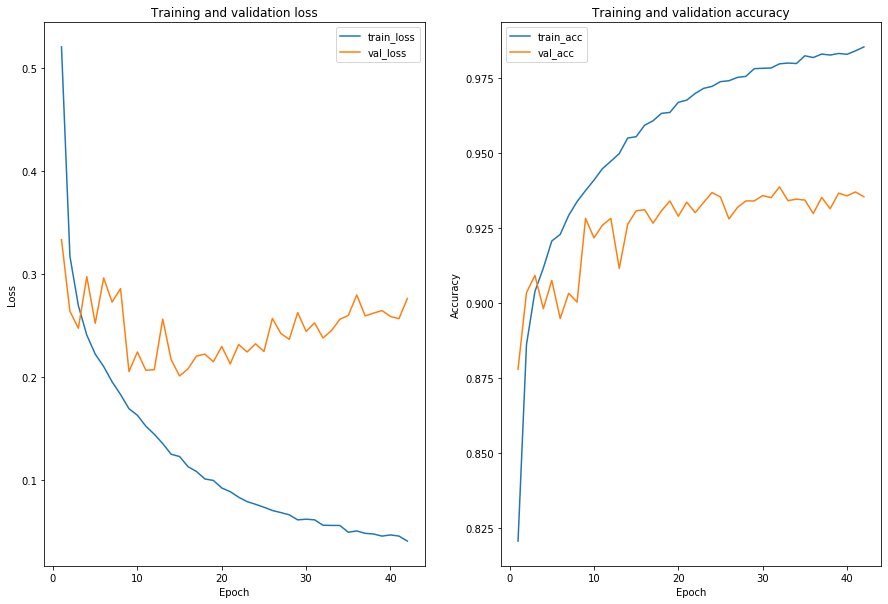

In [3]:
def plot_history(history_df):
    fig, ax = plt.subplots(1, 2, figsize=(15, 10))

    plt.subplot(1, 2, 1)
    plt.plot('epoch', 'loss', data=history_df, label='train_loss')
    plt.plot('epoch', 'val_loss', data=history_df, label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and validation loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot('epoch', 'acc', data=history_df, label='train_acc')
    plt.plot('epoch', 'val_acc', data=history_df, label='val_acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    
plot_history(history_df)

In [4]:
acc_max = history_df.loc[history_df['acc'].idxmax(), :]
print('Maximum training accuracy epoch: \n{}'.format(acc_max))

Maximum training accuracy epoch: 
val_loss     0.275882
val_acc      0.935300
loss         0.040384
acc          0.985260
lr           0.001000
epoch       42.000000
Name: 41, dtype: float64


In [5]:
val_acc_max = history_df.loc[history_df['val_acc'].idxmax(), :]
print('Maximum validation accuracy epoch: \n{}'.format(val_acc_max))

Maximum validation accuracy epoch: 
val_loss     0.237604
val_acc      0.938600
loss         0.055796
acc          0.979620
lr           0.001000
epoch       32.000000
Name: 31, dtype: float64


In [6]:
# Validation accuracy epochs in descending order
history_df.drop(columns=['val_loss', 'loss']).sort_values(by='val_acc', ascending=False)

,val_acc,acc,lr,epoch
31,0.9386,0.97962,0.001,32
40,0.9369,0.98394,0.001,41
23,0.9367,0.97210,0.001,24
38,0.9365,0.98308,0.001,39
29,0.9357,0.97814,0.001,30
39,0.9356,0.98280,0.001,40
41,0.9353,0.98526,0.001,42
24,0.9352,0.97368,0.001,25
36,0.9351,0.98288,0.001,37
30,0.9350,0.97824,0.001,31


We note that $93\%$ accuracy first occured roughly during epochs 15-18, and didn't improve much thereafter.

The last epoch where improvement occured was epoch 32, and since the default model has an early stopping patience of 10 epochs, we know it didn't improve from epochs 32-42 and training stopped after epoch 42.

In [11]:
# Validation loss epochs in descending order
history_df.drop(columns=['val_acc', 'acc']).sort_values(by='val_loss', ascending=True)

,val_loss,loss,lr,epoch
14,0.200692,0.122466,0.001,15
8,0.204977,0.168892,0.001,9
10,0.206213,0.151945,0.001,11
11,0.206824,0.144087,0.001,12
15,0.207615,0.112607,0.001,16
20,0.212421,0.088360,0.001,21
18,0.214470,0.099285,0.001,19
13,0.216433,0.124686,0.001,14
16,0.220042,0.107955,0.001,17
17,0.221858,0.100688,0.001,18


We also note that validation loss was also at an absolute minimum at epoch 14, so here is likely where the model begins to overfit.

## Tuning

### Sagemaker automatic model tuning

We'll use Sagemaker's built-in hyperparameter optimization to try to find a model 
with better validation accuracy. We'll use the (default) Bayesian strategy to search the hyperparameter space efficiently.

In [5]:
# architecture hyperparameter spaces
conv0_hps = {'conv0_pad': IntegerParameter(1, 3),
             'conv0_channels': IntegerParameter(24, 32),
             'conv0_filter': IntegerParameter(2, 4),
             'conv0_stride': IntegerParameter(1, 3),
             'conv0_pool': IntegerParameter(1, 3),
            }
conv1_hps = {'conv1_pad': IntegerParameter(1, 3),
             'conv1_channels': IntegerParameter(48, 64),
             'conv1_filter': IntegerParameter(2, 4),
             'conv1_stride': IntegerParameter(1, 3),
             'conv1_pool': IntegerParameter(1, 3),
            }
conv2_hps = {'conv2_pad': IntegerParameter(1, 3),
             'conv2_channels': IntegerParameter(96, 128),
             'conv2_filter': IntegerParameter(2, 4),
             'conv2_stride': IntegerParameter(1, 3),
             'conv2_pool': IntegerParameter(1, 3),
            }
fc0_hps = {'fc0_neurons': IntegerParameter(200, 300)}
fc1_hps = {'fc1_neurons': IntegerParameter(200, 300)}

hyperparameter_ranges = {**conv0_hps, **conv1_hps, **conv2_hps, **fc0_hps, **fc1_hps}

# objective and metric
objective_metric_name = 'val_acc'
objective_type = 'Maximize'
metric_definitions = [{'Name': 'val_acc',
                       'Regex': 'best_val_acc: ([0-9\\.]+)'}]

# tuner
tuner = HyperparameterTuner(tf_estimator,
                            objective_metric_name,
                            hyperparameter_ranges,
                            metric_definitions,
                            max_jobs=10,
                            max_parallel_jobs=1,
                            objective_type=objective_type)

In [12]:
tuner.fit(paths)

### Analyze tuning job results 

In [55]:
# tuning job results dataframe
tuning_job_df = tuner.analytics().dataframe()
tuning_job_df

,conv0_channels,conv0_filter,conv0_pad,conv0_pool,conv0_stride,conv1_channels,conv1_filter,conv1_pad,conv1_pool,conv1_stride,...,conv2_pool,conv2_stride,fc0_neurons,fc1_neurons,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
0,24.0,3.0,1.0,2.0,3.0,64.0,2.0,1.0,1.0,1.0,...,1.0,2.0,216.0,267.0,tensorflow-training-190920-1614-010-2339cf4b,Completed,0.9104,2019-09-20 17:23:39-07:00,2019-09-20 17:33:02-07:00,563.0
1,29.0,3.0,3.0,1.0,2.0,54.0,4.0,3.0,3.0,1.0,...,1.0,1.0,261.0,218.0,tensorflow-training-190920-1614-009-61a0d8ce,Completed,0.9235,2019-09-20 17:11:08-07:00,2019-09-20 17:20:00-07:00,532.0
2,26.0,2.0,2.0,1.0,3.0,55.0,2.0,2.0,3.0,2.0,...,3.0,3.0,204.0,233.0,tensorflow-training-190920-1614-008-98054b92,Failed,NaN,2019-09-20 17:07:44-07:00,2019-09-20 17:08:55-07:00,71.0
3,26.0,2.0,2.0,1.0,3.0,55.0,2.0,2.0,3.0,2.0,...,3.0,3.0,205.0,233.0,tensorflow-training-190920-1614-007-075957e0,Failed,NaN,2019-09-20 17:04:15-07:00,2019-09-20 17:05:29-07:00,74.0
4,27.0,4.0,2.0,3.0,1.0,63.0,4.0,1.0,1.0,3.0,...,3.0,3.0,225.0,300.0,tensorflow-training-190920-1614-006-b2bfc6ce,Failed,NaN,2019-09-20 17:00:31-07:00,2019-09-20 17:01:49-07:00,78.0
5,27.0,4.0,2.0,3.0,1.0,63.0,4.0,1.0,1.0,3.0,...,3.0,3.0,224.0,299.0,tensorflow-training-190920-1614-005-f7d4ee53,Failed,NaN,2019-09-20 16:56:32-07:00,2019-09-20 16:58:06-07:00,94.0
6,32.0,2.0,3.0,1.0,2.0,58.0,4.0,3.0,1.0,3.0,...,3.0,3.0,253.0,234.0,tensorflow-training-190920-1614-004-527c5a6e,Completed,0.9057,2019-09-20 16:50:07-07:00,2019-09-20 16:54:22-07:00,255.0
7,28.0,2.0,3.0,3.0,2.0,48.0,2.0,1.0,1.0,3.0,...,3.0,2.0,249.0,242.0,tensorflow-training-190920-1614-003-9198b56d,Completed,0.8105,2019-09-20 16:36:50-07:00,2019-09-20 16:46:35-07:00,585.0
8,27.0,2.0,2.0,2.0,2.0,51.0,3.0,3.0,2.0,2.0,...,1.0,2.0,275.0,271.0,tensorflow-training-190920-1614-002-eb3e96e1,Completed,0.8946,2019-09-20 16:27:11-07:00,2019-09-20 16:33:21-07:00,370.0
9,31.0,2.0,1.0,2.0,2.0,57.0,4.0,2.0,1.0,2.0,...,2.0,3.0,214.0,279.0,tensorflow-training-190920-1614-001-f2b7ac23,Completed,0.8983,2019-09-20 16:16:17-07:00,2019-09-20 16:23:07-07:00,410.0


In [56]:
tuning_job_df['TrainingJobStatus']

0    Completed
1    Completed
2       Failed
3       Failed
4       Failed
5       Failed
6    Completed
7    Completed
8    Completed
9    Completed
Name: TrainingJobStatus, dtype: object

We note that 4 out of 10 of the jobs failed. After inspecting the [CloudWatch job logs](console.aws.amazon.com/cloudwatch/home), we found that this was due to inappropropriate hyperparameter range choices leading to negative dimension errors. 

This seems especially problematic if Bayesian optimization is driving the search towards incompatible values of the hyperparameters -- training jobs would be more likely to fail and it would be harder to leave a region of hyperparameter space where such failure is likely. Greater care should be taken to avoide incompatible choices of hyperparameters.

In [58]:
tuning_job_df['FinalObjectiveValue'].sort_values(ascending=False)

1    0.9235
0    0.9104
6    0.9057
9    0.8983
8    0.8946
7    0.8105
2       NaN
3       NaN
4       NaN
5       NaN
Name: FinalObjectiveValue, dtype: float64

Although the validation accuracy improved from job to job, none of the models thus trained achieved a validation accuracy better than the default model,

## Testing

In the end, the default model hyperparameters seemed to be a good option. We'll check the test set performance of the sequence of models learned during [that training job](#Run-a-single-training-job).

As [previously observed](#Analyze-training-history), we expect that weights from this period will perform best on test data, and will be a sound choice for a final model.

In [12]:
! ls models/keras_checkpoints

FashionMNISTCNN-epoch-01-val_acc-0.8778.hdf5
FashionMNISTCNN-epoch-02-val_acc-0.9033.hdf5
FashionMNISTCNN-epoch-03-val_acc-0.9091.hdf5
FashionMNISTCNN-epoch-09-val_acc-0.9281.hdf5
FashionMNISTCNN-epoch-12-val_acc-0.9281.hdf5
FashionMNISTCNN-epoch-15-val_acc-0.9306.hdf5
FashionMNISTCNN-epoch-16-val_acc-0.9310.hdf5
FashionMNISTCNN-epoch-19-val_acc-0.9339.hdf5
FashionMNISTCNN-epoch-24-val_acc-0.9367.hdf5
FashionMNISTCNN-epoch-32-val_acc-0.9386.hdf5
FashionMNISTCNN-history.csv
dummy.txt


We'll evaluate all models between epochs 15-32

In [18]:
def epoch_and_val_acc_from_file_name(model_file):
    model_file = model_file.lstrip('FashionMNISTCNN-')
    model_file = model_file.rstrip('.hdf5')
    model_file = model_file.split('-')
    epoch = int(model_file[1])
    val_acc = float(model_file[3])
    return epoch, val_acc

def get_models_from_dir(model_dir, epoch_range, input_shape=(28, 28, 1), drop_rate=0.50):
    models = {}
    for _, _, model_files in os.walk(model_dir):
        for model_file in sorted(model_files):
            if '.hdf5' in model_file:
                epoch, val_acc = epoch_and_val_acc_from_file_name(model_file)
                if epoch in epoch_range:
                    model = fmc(input_shape=input_shape, drop_rate=drop_rate)
                    model.load_weights(os.path.join(model_dir, model_file))
                    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
                    models[epoch] = model
    return models

def model_eval_df(models, X, Y):
    losses, accs = [], []
    for epoch in models:
        print("Evaluating epoch {} model:\n".format(epoch))
        loss, acc = models[epoch].evaluate(x=X, y=Y)
        losses += [loss]
        accs += [acc]
    eval_df = pd.DataFrame({'epoch': list(models.keys()), 'test_loss': losses, 'test_acc': accs})
    return eval_df

In [19]:
# load and prepare test data
(X_train, Y_train, X_val, Y_val, X_test, Y_test) = fmc.load_data()
(X_train, Y_train, X_val, Y_val, X_test, Y_test) = fmc.prepare_data(X_train, Y_train, X_val, Y_val, X_test, Y_test)
#evaluate models
epoch_range = range(15, 33)
models = get_models_from_dir('models/keras_checkpoints', epoch_range)
model_test_eval_df = model_eval_df(models, X_test, Y_test)

Evaluating epoch 15 model:

10000/10000 [==============================] - 26s 3ms/step
Evaluating epoch 16 model:

10000/10000 [==============================] - 27s 3ms/step
Evaluating epoch 19 model:

10000/10000 [==============================] - 25s 3ms/step
Evaluating epoch 24 model:

10000/10000 [==============================] - 27s 3ms/step
Evaluating epoch 32 model:

10000/10000 [==============================] - 26s 3ms/step


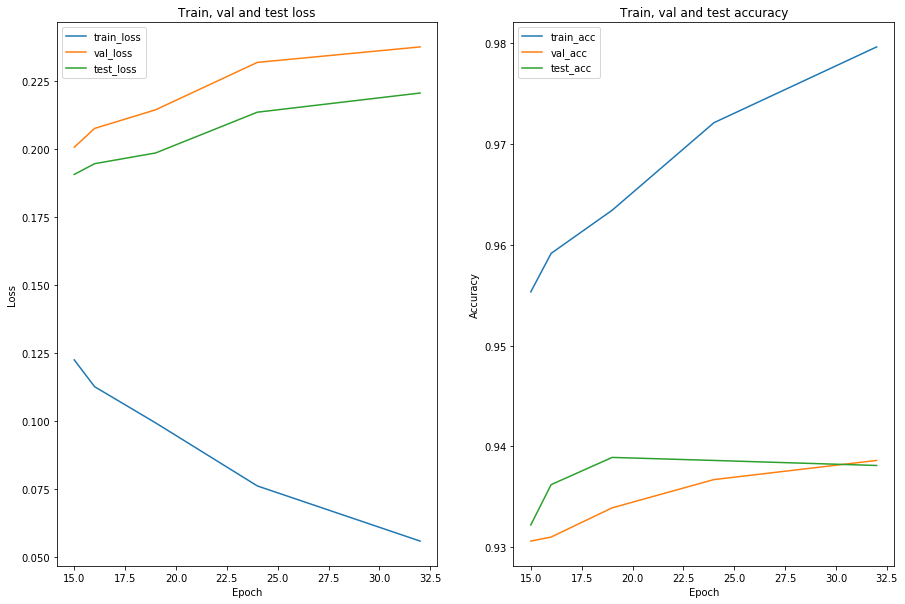

In [26]:
def plot_performance(model_df):
    fig, ax = plt.subplots(1, 2, figsize=(15, 10))

    plt.subplot(1, 2, 1)
    plt.plot('epoch', 'loss', data=model_df, label='train_loss')
    plt.plot('epoch', 'val_loss', data=model_df, label='val_loss')
    plt.plot('epoch', 'test_loss', data=model_df, label='test_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Train, val and test loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot('epoch', 'acc', data=model_df, label='train_acc')
    plt.plot('epoch', 'val_acc', data=model_df, label='val_acc')
    plt.plot('epoch', 'test_acc', data=model_df, label='test_acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Train, val and test accuracy')
    plt.legend()
    
model_df = pd.merge(history_df, model_test_eval_df, on='epoch')
plot_performance(model_df)

In [30]:
# epochs ranked by test accuracy
model_df.sort_values(by='test_acc', ascending=False)

,val_loss,val_acc,loss,acc,lr,epoch,test_loss,test_acc
2,0.214470,0.9339,0.099285,0.96342,0.001,19,0.198591,0.9389
3,0.231908,0.9367,0.076089,0.97210,0.001,24,0.213586,0.9386
4,0.237604,0.9386,0.055796,0.97962,0.001,32,0.220641,0.9381
1,0.207615,0.9310,0.112607,0.95914,0.001,16,0.194638,0.9362
0,0.200692,0.9306,0.122466,0.95532,0.001,15,0.190690,0.9322


In [31]:
# epochs ranked by test loss
model_df.sort_values(by='test_loss', ascending=True)

,val_loss,val_acc,loss,acc,lr,epoch,test_loss,test_acc
0,0.200692,0.9306,0.122466,0.95532,0.001,15,0.190690,0.9322
1,0.207615,0.9310,0.112607,0.95914,0.001,16,0.194638,0.9362
2,0.214470,0.9339,0.099285,0.96342,0.001,19,0.198591,0.9389
3,0.231908,0.9367,0.076089,0.97210,0.001,24,0.213586,0.9386
4,0.237604,0.9386,0.055796,0.97962,0.001,32,0.220641,0.9381


As a compromise between test accuracy and loss, we'll select the epoch 19 model for the final model.

## Conclusions

We found that the default model architecture performed well with a test classifiction accuracy of $\approx 93.9\%$ and a categorical cross entropy loss of $\approx 0.199$.

Some possibilities for model improvement are:
- Using data augmentation to increase the size of the training set. This is very easy to implement in Keras
- Better hyperparameter tuning, particularly architecture parameters. This could be done by a more careful definition of the hyperparameter spaces used in [Bayesian tuning](#Analyze-tuning-job-results), or by random search nearby the default hyperparameters